In [1]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10


# **Load & Preprocess CIFAR-10**

In [2]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Resize to 32 to match ResNet50 input size
IMG_SIZE = 32
x_train_resized = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)).numpy()
x_test_resized = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)).numpy()

# Preprocess images for ResNet
x_train_resnet = preprocess_input(x_train_resized)
x_test_resnet = preprocess_input(x_test_resized)

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


# **Load Pretrained ResNet50 & Add Custom Head**

In [3]:
# Load base model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# **Compile and Train**

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)

# Train
history = model.fit(x_train_resnet, y_train_cat,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 238s 183ms/step - accuracy: 0.4585 - loss: 1.8732 - val_accuracy: 0.6092 - val_loss: 1.0960 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 295s 209ms/step - accuracy: 0.5894 - loss: 1.1610 - val_accuracy: 0.6325 - val_loss: 1.0512 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 208ms/step - accuracy: 0.6159 - loss: 1.0841 - val_accuracy: 0.6368 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 208ms/step - accuracy: 0.6220 - loss: 1.0577 - val_accuracy: 0.6394 - val_loss: 1.0220 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 208ms/step - accuracy: 0.6330 - loss: 1.0299 - val_accuracy: 0.6515 - val_loss: 1.0017 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 209ms/step - accuracy: 0.6449 - loss: 1.0136 - val_accuracy: 0.6527 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 258s 206ms

# **Fine-Tune Top Layers**

In [5]:
# Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(x_train_resnet, y_train_cat,
                              epochs=10,
                              batch_size=32,
                              validation_split=0.2,
                              callbacks=[early_stop, reduce_lr])


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 605s 475ms/step - accuracy: 0.7023 - loss: 0.8429 - val_accuracy: 0.6679 - val_loss: 0.9689 - learning_rate: 1.0000e-05
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 620s 473ms/step - accuracy: 0.7177 - loss: 0.7971 - val_accuracy: 0.6717 - val_loss: 0.9631 - learning_rate: 1.0000e-05
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 620s 472ms/step - accuracy: 0.7163 - loss: 0.7863 - val_accuracy: 0.6749 - val_loss: 0.9591 - learning_rate: 1.0000e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 623s 473ms/step - accuracy: 0.7255 - loss: 0.7735 - val_accuracy: 0.6759 - val_loss: 0.9564 - learning_rate: 1.0000e-05
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 632s 481ms/step - accuracy: 0.7291 - loss: 0.7595 - val_accuracy: 0.6746 - val_loss: 0.9569 - learning_rate: 1.0000e-05
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 624s 483ms/step - accuracy: 0.7383 - loss: 0.7417 - val_accuracy: 0.6748 - val_loss: 0.9560 - learning_rate: 1.0000e-05
Epoch 7/10
1250/1250 ━━━━━━━

# **Evaluate & Plot**

313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.6681 - loss: 0.9701
Final Test Accuracy: 66.85%


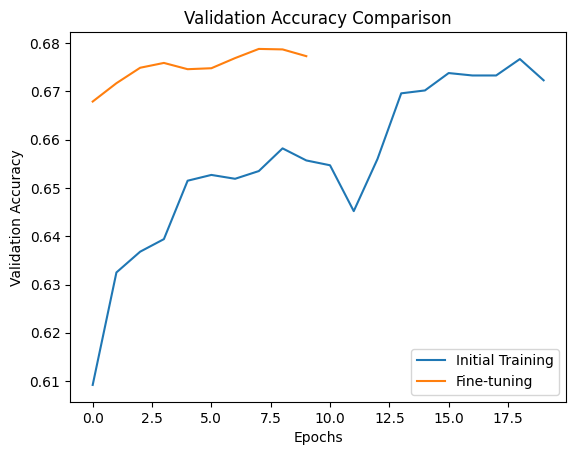

In [6]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test_resnet, y_test_cat)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# Plot training history
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.plot(history.history['val_accuracy'], label=title)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title("Validation Accuracy Comparison")
    plt.show()

plot_history([history, fine_tune_history], ['Initial Training', 'Fine-tuning'])


### 🔍 Model Comparison Table

| Feature                     | ResNet50                      | MobileNetV2                   |
|----------------------------|-------------------------------|-------------------------------|
| **Input Image Size**       | 224 × 224 × 3                 | 224 × 224 × 3                 |
| **Parameters**             | ~25.6 Million                 | ~3.5 Million                  |
| **Layers / Depth**         | 50 layers                     | ~88 layers                    |
| **ImageNet Accuracy (Top-1)** | ~76.0%                    | ~72.0%                        |
| **Model Size (MB)**        | ~98 MB                        | ~14 MB                        |
| **Inference Speed**        | Slower (heavier)              | Faster (lightweight)          |


**Justification of Selected Model:**

ResNet50 was selected for this project due to its superior accuracy and proven performance on a variety of image classification tasks. While MobileNetV2 is faster and more lightweight, ResNet50 is more robust and suitable for our training setup since deployment constraints are not a priority.
